In [1]:
## import libraries
import os, sys
import yaml
import re
import xarray as xr
import pandas as pd
import numpy as np
from datetime import timedelta
%matplotlib inline
from datetime import timedelta

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import textwrap
import cmocean.cm as cmo
import matplotlib.patches as mpatches

# import personal modules
sys.path.append('../modules')
import custom_cmaps as ccmap
from plotter import draw_basemap
import ar_funcs
# dask.config.set(**{'array.slicing.split_large_chunks': True})

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [7]:
## bounding boxes for composite analysis
bboxes = [[-140.5, -137., 58.25, 60.75], # Yakutat (Northern Coastal)
          [-136.5, -134.75, 56.0, 58.25], # Sitka / Hoonah (Central Coastal)
          [-137.0, -134.75, 58.25, 60.5], # Skagway/Klukwan/Haines (Northern Inner Channel)
          [-134.75, -132.5, 56.75, 58.5], # Juneau/Hoonah/Gustavas (Central Inner Channel)
          [-134.25, -132.5, 54.25, 56.75], # Craig (Southern Coastal)
          [-132.5, -131.25, 54.5, 56.75]] # Kasaan (Southern Inner Channel)

zone_lst = ['northern_coastal', 'central_coastal', 'northern_inner_channel', 'central_inner_channel', 'southern_coastal', 'southern_inner_channel']
# zone_lst = ['coastal', 'inner_channel']
# region_lst = ['northern', 'central', 'southern']
impact_level_lst = ['low', 'medium', 'high']
varname = 'freezing_level' # 'freezing_level' or 'ivt'

In [15]:
dates_lst = []
for j, zone in enumerate(zone_lst):
    fname = '../out/test_75percent_coverage/{0}_{1}_impact_precip_dates.csv'.format(zone, 'high')
    df = pd.read_csv(fname)
    ts = pd.to_datetime(df.date.values)
    d = {'dates': ts}
    df = pd.DataFrame(d)
    dates_lst.append(df)

df = pd.concat(dates_lst)
df = df.drop_duplicates()
df.to_csv('../out/high_impact_precip_dates_all.csv')

In [18]:
fname = '../out/high_impact_precip_dates_all.csv'
ar_df = pd.read_csv(fname) # read in AR dates
ar_df = ar_df.set_index(pd.to_datetime(ar_df['dates']))
ar_dates = ar_df.index.values
ar_dates

array(['2000-09-06T00:00:00.000000000', '2000-10-06T00:00:00.000000000',
       '2000-12-05T00:00:00.000000000', '2001-01-03T00:00:00.000000000',
       '2001-01-07T00:00:00.000000000', '2001-02-26T00:00:00.000000000',
       '2001-02-27T00:00:00.000000000', '2001-09-13T00:00:00.000000000',
       '2002-03-02T00:00:00.000000000', '2002-08-12T00:00:00.000000000',
       '2002-08-21T00:00:00.000000000', '2002-10-12T00:00:00.000000000',
       '2002-10-16T00:00:00.000000000', '2002-11-26T00:00:00.000000000',
       '2002-11-27T00:00:00.000000000', '2003-01-18T00:00:00.000000000',
       '2003-08-15T00:00:00.000000000', '2003-12-22T00:00:00.000000000',
       '2004-02-11T00:00:00.000000000', '2004-03-10T00:00:00.000000000',
       '2004-04-02T00:00:00.000000000', '2004-04-03T00:00:00.000000000',
       '2004-09-26T00:00:00.000000000', '2004-10-29T00:00:00.000000000',
       '2004-12-22T00:00:00.000000000', '2005-02-27T00:00:00.000000000',
       '2005-08-24T00:00:00.000000000', '2005-09-28

In [4]:
## load the preprocessed mclimate comparison to AR dates at 72 hour lead
fname_pattern = path_to_data + 'preprocessed/mclimate_AR_dates/mclimate_{0}_*_F72.nc'.format(varname)
ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', combine='nested', concat_dim="valid_time")

In [25]:
tmp_lst = []
dates_lst = []
for i, impact_level in enumerate(impact_level_lst):
    ds_lst = []
    for j, zone in enumerate(zone_lst):
        fname = '../out/test_75percent_coverage/{0}_{1}_impact_precip_dates.csv'.format(zone, impact_level)
        df = pd.read_csv(fname)
        ts = pd.to_datetime(df.date.values)
        dates_lst.append(ts)
        print(len(ts))
        tmp = ds.sel(valid_time=ts) # subset to high/medium/low impact dates
        tmp = tmp.mean('valid_time') # average the composite
        # tmp = tmp.expand_dims(dim={"impact_level": 1})
        # tmp = tmp.expand_dims(dim={"region": 1})
        # tmp = tmp.assign_coords({"impact_level": impact_level, "region":  zone})
        ds_lst.append(tmp)

    tmp = xr.concat(ds_lst, pd.Index(zone_lst, name="region"))
    tmp_lst.append(tmp)
ds = xr.concat(tmp_lst, pd.Index(impact_level_lst, name="impact_level"))
ds

1060
1044
1092
1073
1131
1165
184
243
245
235
143
167
106
121
109
99
77
84


<xarray.Dataset>
Dimensions:       (impact_level: 3, region: 6, lat: 241, lon: 279)
Coordinates:
  * lat           (lat) float64 70.0 69.75 69.5 69.25 ... 10.75 10.5 10.25 10.0
  * lon           (lon) float64 -179.5 -179.2 -179.0 ... -110.5 -110.2 -110.0
  * region        (region) object 'northern_coastal' ... 'southern_inner_chan...
  * impact_level  (impact_level) object 'low' 'medium' 'high'
Data variables:
    mclimate      (impact_level, region, lat, lon) float64 dask.array<chunksize=(1, 1, 241, 279), meta=np.ndarray>

In [37]:
ds = ds.load()

In [60]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = ds.lat.values
lons = ds.lon.values
dx = np.arange(lons.min().round(),lons.max().round()+10,10)
dy = np.arange(lats.min().round(),lats.max().round()+5,5)

ext = [-170., -120., 40., 65.] ## npacific
ext = [-141., -130., 54.5, 60.] ## seak

In [61]:
def create_mclimate_composite_plot(ds, region_lst, bbox_lst, zone_name, varname):
    # Create figure
    fig = plt.figure(figsize=(10, 6))
    fig.dpi = 300
    fname = path_to_figs + 'impact_composite_{0}_{1}'.format(zone_name, varname)
    fmt = 'png'
    
    nrows = 5
    ncols = 3
    
    # contour labels
    kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    
    kw_ticklabels = {'size': 10, 'color': 'dimgray', 'weight': 'light'}
    
    ## Use gridspec to set up a plot with a series of subplots that is
    ## n-rows by n-columns
    gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 0.05, 0.05], width_ratios = [1, 1, 1], wspace=0.05, hspace=0.05)
    ## use gs[rows index, columns index] to access grids
    
    ###################
    ### CLIMATOLOGY ###
    ###################
    llats_lst = [True, False, False]
    blons_lst = [False, False, True]
    lbl = ['Low Impact', 'Medium Impact', 'High Impact']
    region_lbl = ['Northern', 'Central', 'Southern']
    impact_level_lst = ['low', 'medium', 'high']
    for i, impact_level in enumerate(impact_level_lst):
        for j, region in enumerate(region_lst):
            print(j, i)
            ax = fig.add_subplot(gs[j, i], projection=mapcrs) 
            ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=llats_lst[i], right_lats=False, bottom_lons=blons_lst[j])
            
            # Contour Filled
            data = ds.sel(impact_level=impact_level, region=region)
            # cmap, norm, bnds = ccmap.cmap('mclimate_purple')
            cmap = cmo.deep
            bnds = np.arange(75, 101, 1)
            cf = ax.contourf(data.lon, data.lat, data.mclimate.values*100, transform=datacrs,
                             levels=bnds, cmap=cmap, alpha=0.9, extend='neither')
            
            ## add region boxes
            bbox = bbox_lst[j]
            ax.add_patch(mpatches.Rectangle(xy=[bbox[0], bbox[2]], width=bbox[1]-bbox[0], height=bbox[3]-bbox[2],
                                    fill=False,
                                    edgecolor='r',
                                    linewidth=0.75,
                                    transform=datacrs,
                                    zorder=199))
            ## add labels
            if j == 0:
                ax.set_title(lbl[i], loc='left', fontsize=10)

            if i == 0: # add row labels to the far left plot
                ax.text(-0.16, 0.5, region_lbl[j], va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor', fontsize=13,
                    transform=ax.transAxes)
    
    # Add color bar
    cbax = plt.subplot(gs[-1,:]) # colorbar axis
    cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
    cb.set_label('Model Climate Percentile Rank (xth)', fontsize=10)
    cb.ax.tick_params(labelsize=8)
    
    fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
    
    # Show
    plt.show()

0 0
1 0
2 0
0 1
1 1
2 1
0 2
1 2
2 2


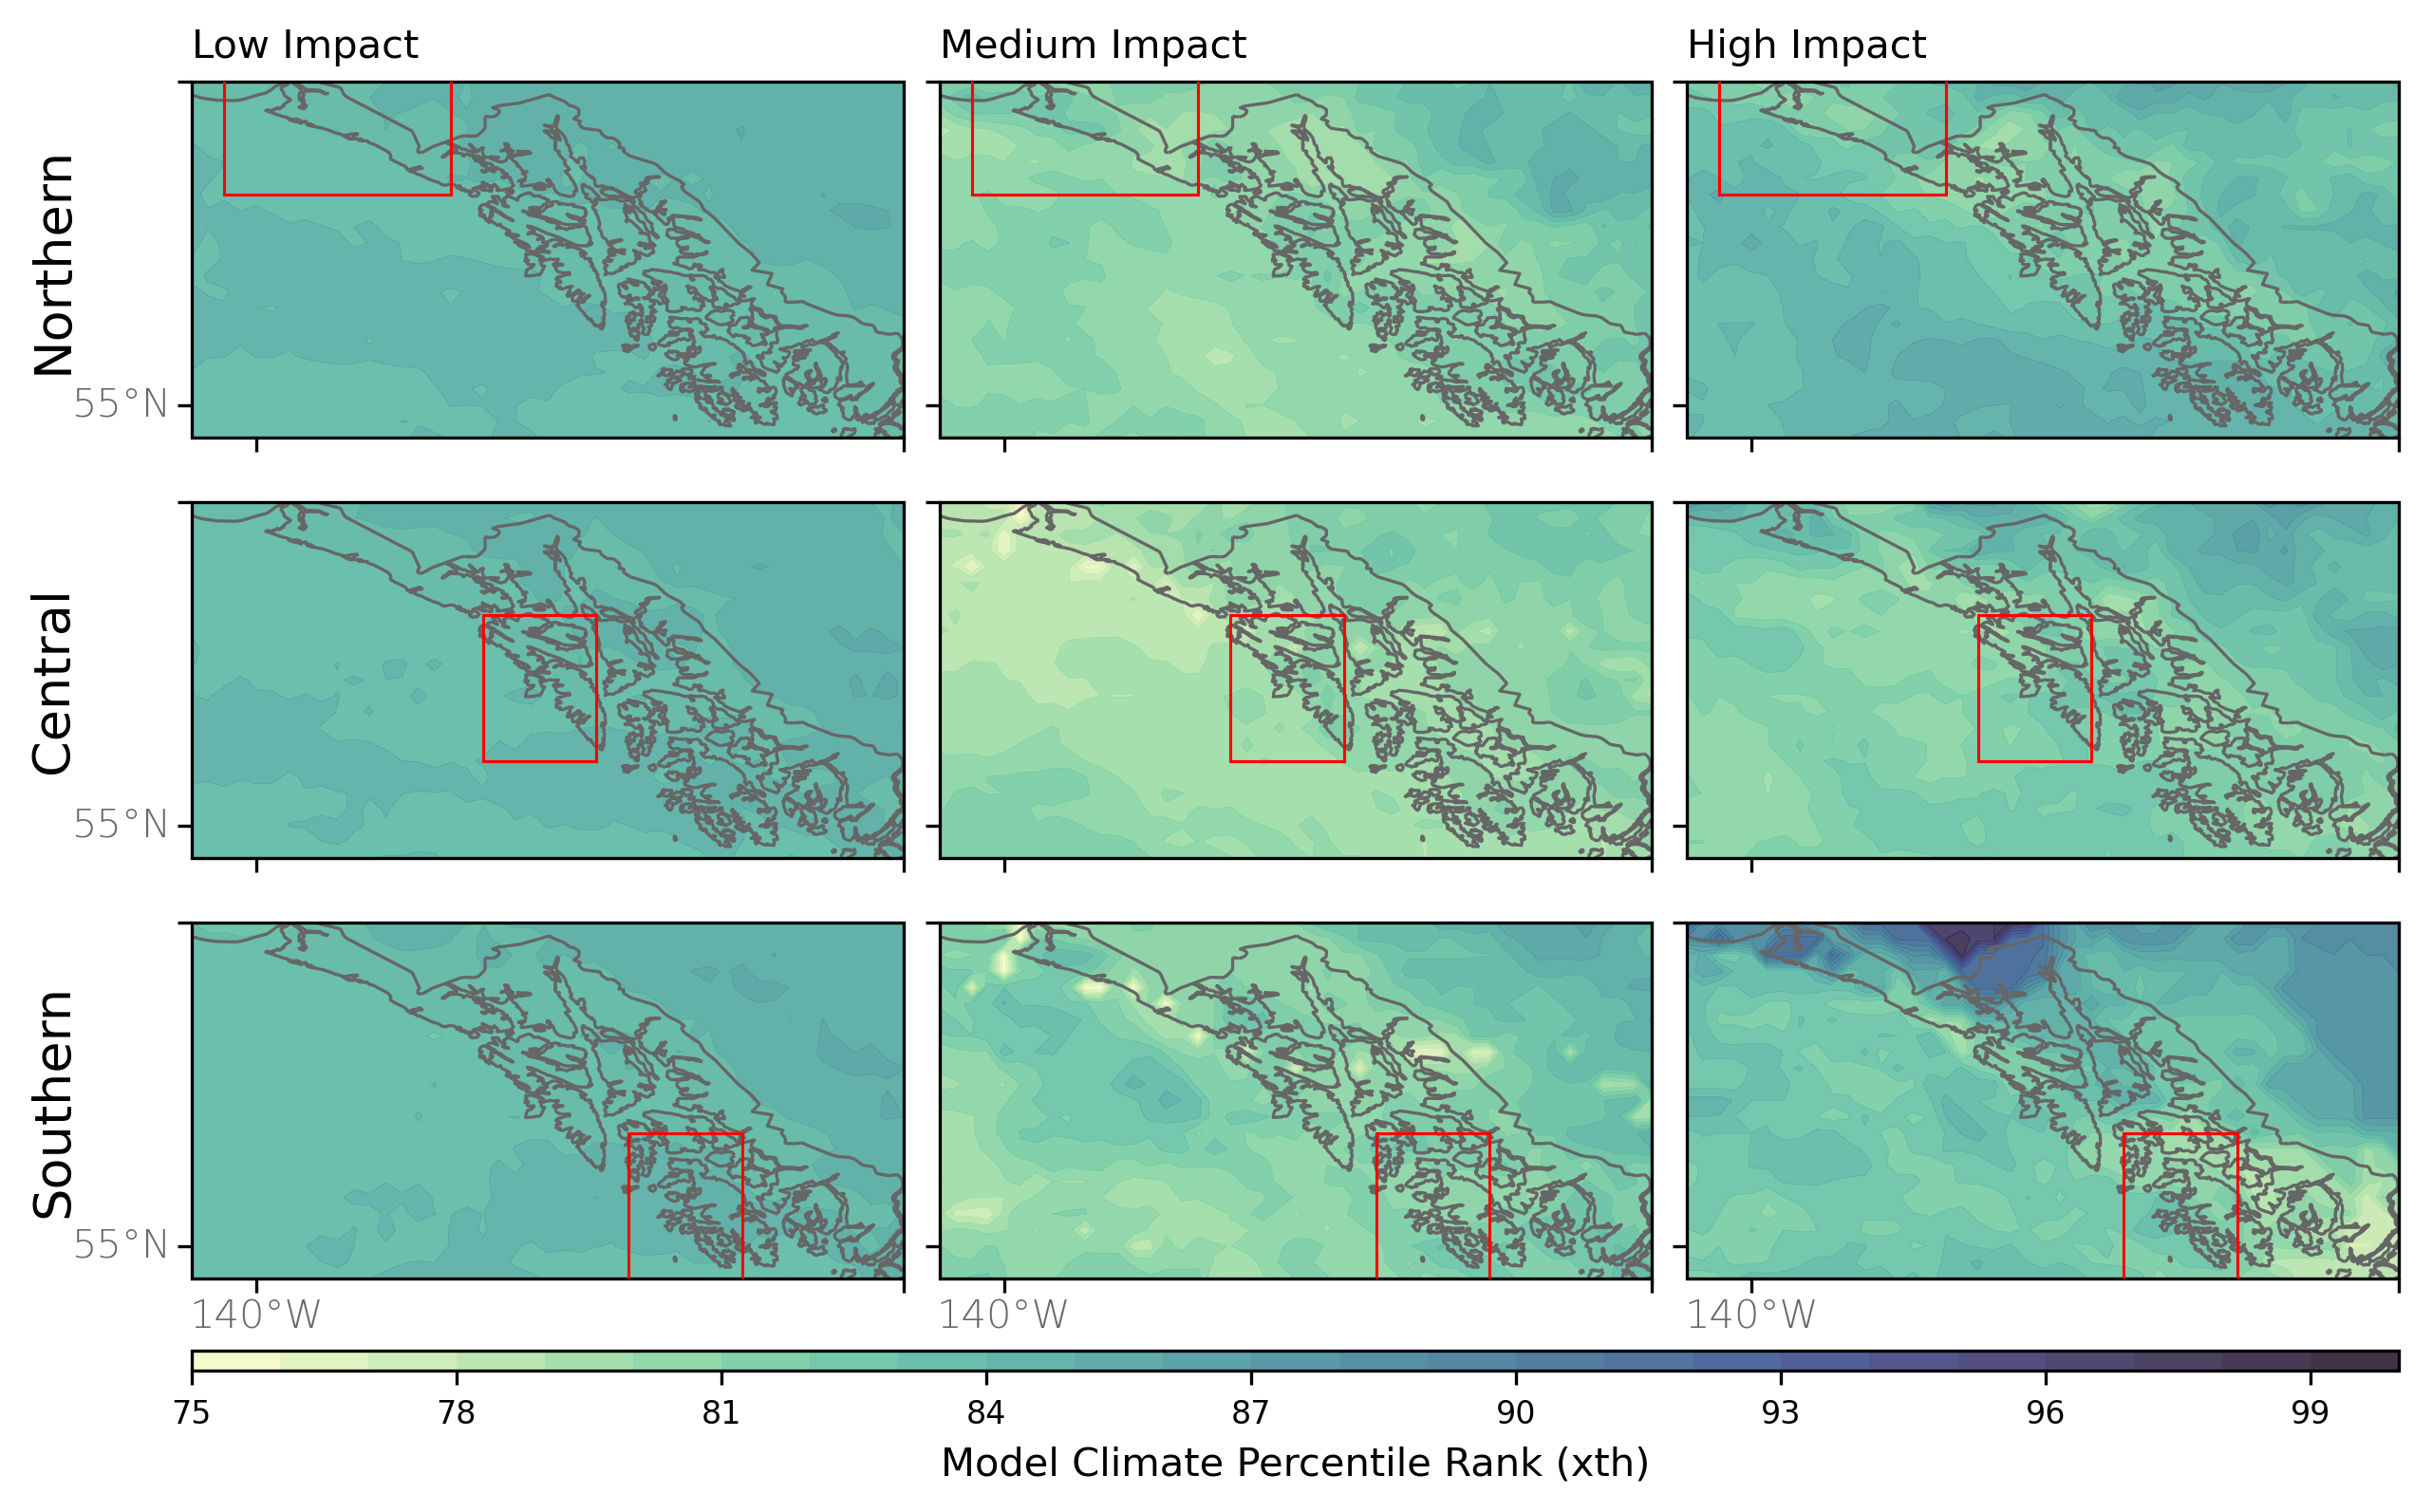

0 0
1 0
2 0
0 1
1 1
2 1
0 2
1 2
2 2


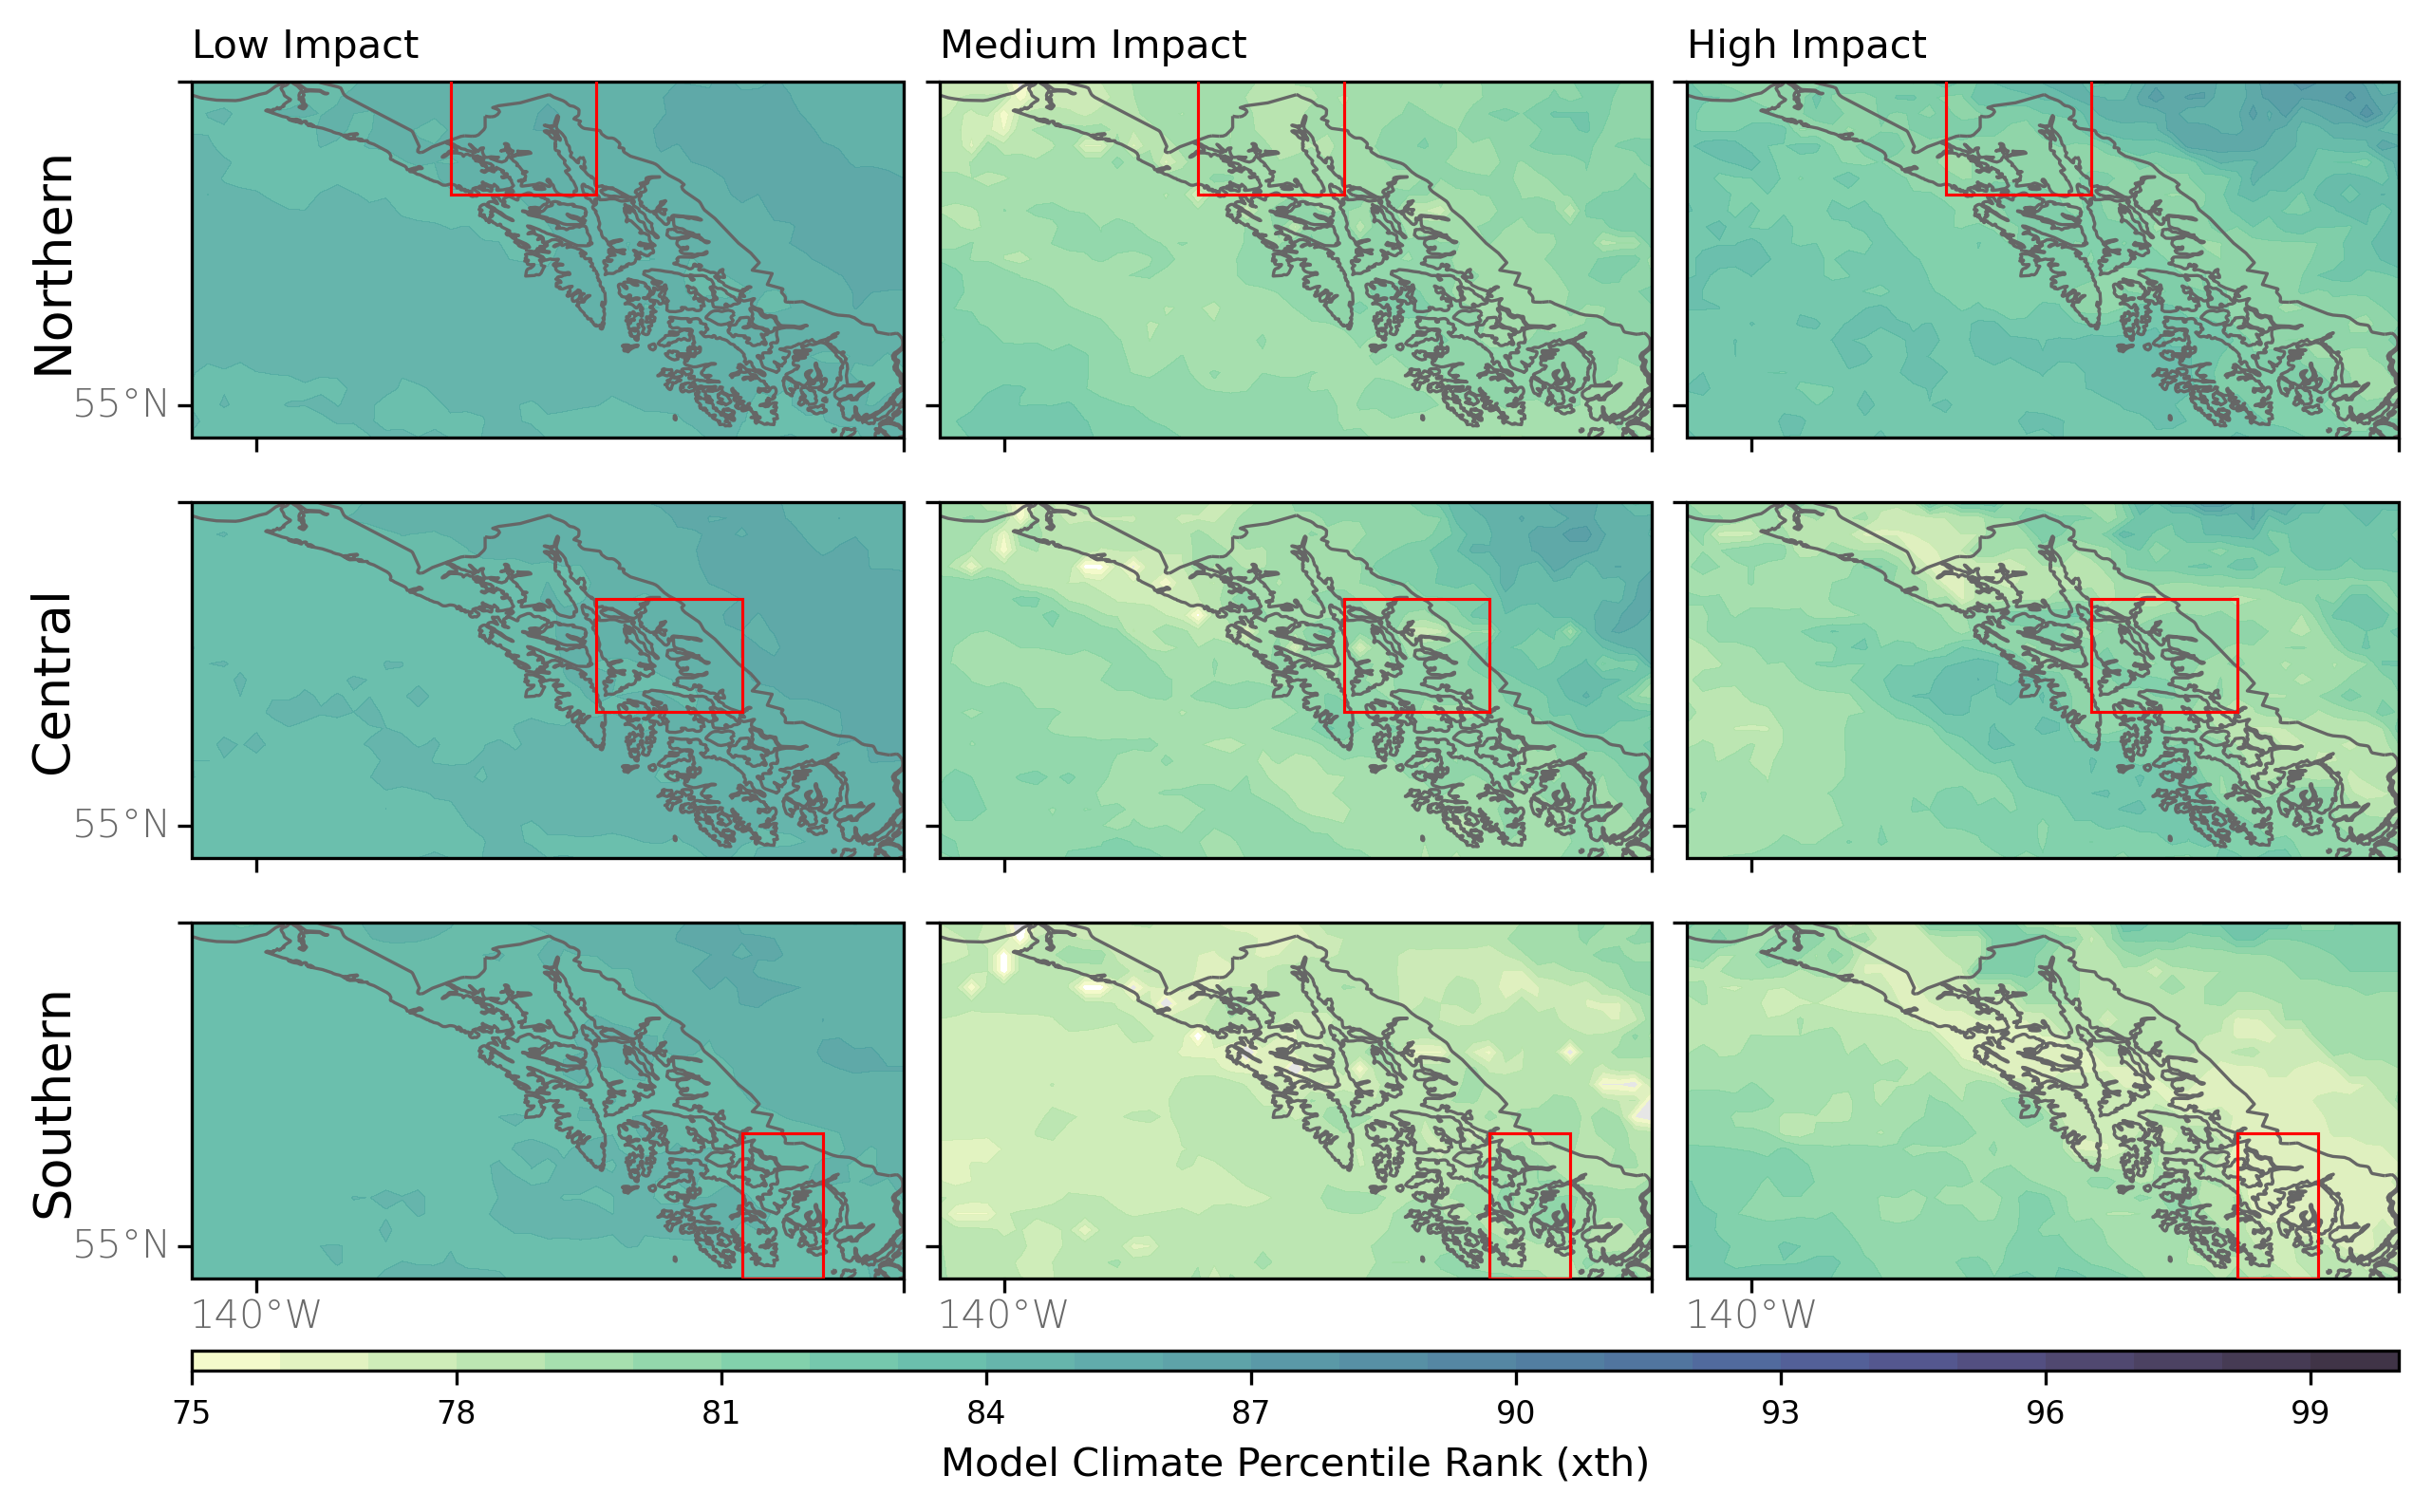

In [62]:
## two plots - one coastal regions, one inner channel

region_lst = ['northern_coastal', 'central_coastal', 'southern_coastal']
bbox_lst = [[-140.5, -137., 58.25, 60.75], # Yakutat (Northern Coastal)
            [-136.5, -134.75, 56.0, 58.25], # Sitka / Hoonah (Central Coastal)
            [-134.25, -132.5, 54.25, 56.75]] # Craig (Southern Coastal)

create_mclimate_composite_plot(ds, region_lst, bbox_lst, 'coastal', varname)

region_lst = ['northern_inner_channel', 'central_inner_channel', 'southern_inner_channel']
bbox_lst = [[-137.0, -134.75, 58.25, 60.5], # Skagway/Klukwan/Haines (Northern Inner Channel)
            [-134.75, -132.5, 56.75, 58.5], # Juneau/Hoonah/Gustavas (Central Inner Channel)
            [-132.5, -131.25, 54.5, 56.75]] # Kasaan (Southern Inner Channel)

create_mclimate_composite_plot(ds, region_lst, bbox_lst, 'inner_channel', varname)